In [55]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats
from sklearn.utils import resample
import math
import matplotlib.pyplot as plt
from matplotlib import pyplot


In [67]:
# interesting explanation here: http://www.statisticshowto.com/probability-and-statistics/confidence-interval/

In [105]:
# Empirical Confidence Intervals using Bootstrap:
# https://machinelearningmastery.com/calculate-bootstrap-confidence-intervals-machine-learning-results-python/  

To keep in mind. 
- When a $\alpha=95%$ C.I. is asked => The values at the 2.5 ($(1-\alpha)/2)$) and 97.5 ($ \alpha+((1-\alpha)/2)$) percentiles are selected.

## Use-Case: CI for normal distribution - Bootstrap

The size of the sample taken each iteration may be limited to e.g. 60% or 80% of the available data. This will mean that there will be some samples that are not included in the sample. These are called out of bag (OOB) samples.

In [ ]:
# This is our distribution (we assume gaussian)
data = np.random.normal(240, 25, 1000)

### - using Bootstrap

In [15]:
# we want to calcluate the 95CI (alpha = 0.95)
alpha = 0.95

# out data
data = np.random.normal(240, 25, 1000)
print "The sample mean is: ", data.mean()

# now we get the least of mean values using bootstrap in an iteration
# bootstrap leaves out 20% 
n_size = int(len(data) * 0.80)
means = []
for iteration in range(0, 1000):
    data_bootstrap = resample(data, n_samples=n_size)
    means.append(data_bootstrap.mean())
    
# get the confidence intervals 
# confidence intervals
p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(means, p)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(means, p)
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower, upper))

The sample mean is:  239.35046995406907
95.0 confidence interval 237.6% and 241.1%


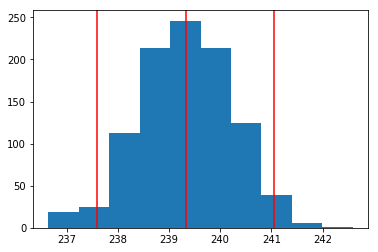

In [16]:
# plot The histogram of means
m = np.array(means).mean()
_ = plt.hist(means)
_ = plt.axvline(x=m, color='red')
_ = plt.axvline(x=lower, color='red')
_ = plt.axvline(x=upper, color='red'); 

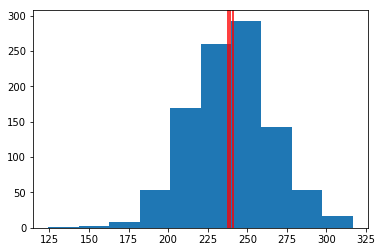

In [17]:
# plot the histogram of initial data with the confidence intervals
_ = plt.hist(data)
_ = plt.axvline(x=m, color='red')
_ = plt.axvline(x=lower, color='red')
_ = plt.axvline(x=upper, color='red'); 

### - using t-distribution table

In [18]:


# This is the wanted confidence level
CL = 0.95 

# we calculate the degrees of freedom
N = len(data)
dof = N-1 # degrees of freedom ~ N for big numbers.

# we use a t-distribution table (here from scipy) 
# ppf: percent point function (inverse of cdf)
t_table_val = scipy.stats.t.ppf((1-CL)/2., dof)

m = np.mean(data)
h = np.std(data)/math.sqrt(N) * t_table_val
print t_table_val, np.std(data)/math.sqrt(N) , h,  m-h, m+h

-1.9623414611334487 0.8183743775066977 -1.6059299717106696 240.95639992577975 237.7445399823584


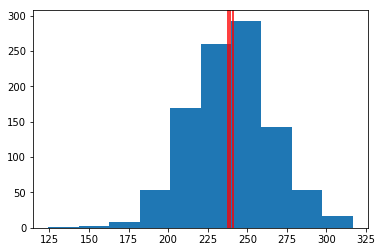

In [19]:
_ = plt.hist(data)
_ = plt.axvline(x=m, color='red')
_ = plt.axvline(x=m-h, color='red'); _ = plt.axvline(x=m+h, color='red')

## Use-Case: Confidence and Prediction Intervals of correlation

0.0
0.0
0.0


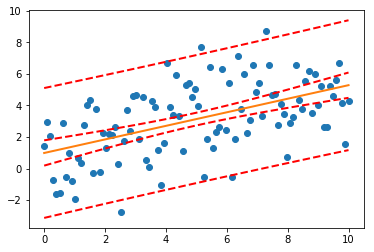

In [100]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from statsmodels.sandbox.regression.predstd import wls_prediction_std

nmuestra = 100

x = np.linspace(0, 10, nmuestra)
e = np.random.normal(size=nmuestra)
y = 1 + 0.5*x + 2*e
X = sm.add_constant(x)

re = sm.OLS(y, X).fit()

st, data, ss2 = summary_table(re, alpha=0.05)

prstd, iv_l, iv_u = wls_prediction_std(re)



fittedvalues = data[:,2]
predict_mean_se  = data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T
predict_ci_low, predict_ci_upp = data[:,6:8].T

# check we got the right things
print np.max(np.abs(re.fittedvalues - fittedvalues))
print np.max(np.abs(iv_l - predict_ci_low))
print np.max(np.abs(iv_u - predict_ci_upp))

plt.plot(x, y, 'o')
plt.plot(x, fittedvalues, '-', lw=2)
plt.plot(x, predict_ci_low, 'r--', lw=2)
plt.plot(x, predict_ci_upp, 'r--', lw=2)
plt.plot(x, predict_mean_ci_low, 'r--', lw=2)
plt.plot(x, predict_mean_ci_upp, 'r--', lw=2)
plt.show()

## Use-Case: Confidence Intervals for Classification Score

In [29]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [31]:
# The typicall case where we calculate the scores (without any confidence intervals)
iris=datasets.load_iris()
x_train, x_test, y_train, y_test=train_test_split(iris.data,iris.target,test_size=0.33)
clf=KNeighborsClassifier(n_neighbors=3).fit(x_train, y_train)

a = accuracy_score(y_test, clf.predict(x_test))
p = precision_score(y_test, clf.predict(x_test), average='weighted')
r = recall_score(y_test, clf.predict(x_test), average='weighted')
print "accuracy: ",a, " precision: ", p, " recall: ", r

accuracy:  0.98  precision:  0.98125  recall:  0.98


In [59]:
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                columns= iris['feature_names'] + ['target'])
df.head(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0


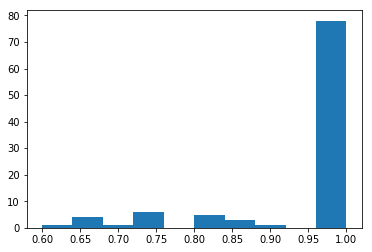

95.0 confidence interval 66.7% and 100.0%


In [118]:
# now we ll calculate the scores adding the CI using bootstrap
values = df.values
# configure bootstrap
n_iterations = 100
n_size = int(len(data) * 0.50)

# run bootstrap
stats = list()
for i in range(n_iterations):
    try:
        # prepare train and test sets
        train = resample(values,replace=True, n_samples=n_size)
        test = np.array([x for x in values if x.tolist() not in train.tolist()])
       
        # fit model
        model = KNeighborsClassifier(n_neighbors=5)
        model.fit(train[:, :-1], train[:,-1])
        a = accuracy_score(test[:,-1], model.predict(test[:,:-1]))
        stats.append(a)

    except:
        pass
# plot scores
pyplot.hist(stats)
pyplot.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

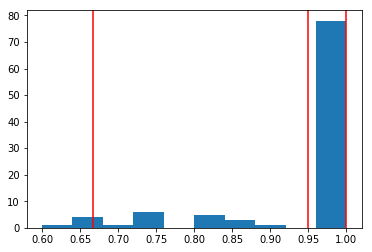

In [119]:
_ = plt.hist(stats)
_ = plt.axvline(x=np.array(stats).mean(), color='red')
_ = plt.axvline(x=lower, color='red'); _ = plt.axvline(x=upper, color='red')